In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
core = ov.Core()
model_face = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model_face = core.compile_model(model = model_face, device_name="CPU")
input_layer_face = compiled_model_face.input(0)
output_layer_face = compiled_model_face.output(0)

model_emo = core.read_model(model='models/emotions-recognition-retail-0003.xml')
compiled_model_emo = core.compile_model(model = model_emo, device_name="CPU")
input_layer_emo = compiled_model_emo.input(0)
output_layer_emo = compiled_model_emo.output(0)

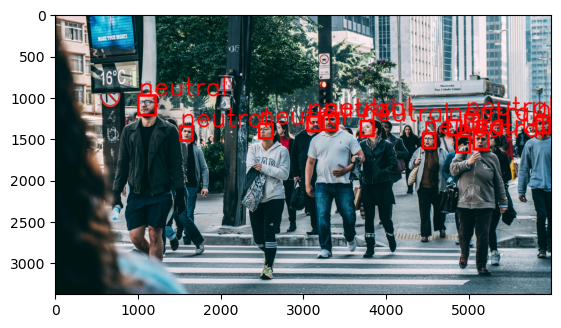

In [52]:
image = cv2.imread("persons.jpg")
input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]
confidence_threshold = .05
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_faceboxes(image, face_boxes, scores)
draw_emotions(face_boxes, image, show_image)
plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [48]:
def draw_emotions(face_boxes, image, show_image):
    EMOTION_NAMES = ['neutral', 'happy', 'sad', 'suprise', 'anger']
    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        face = image[ymin:ymax, xmin:xmax]
        input_image = preprocess(image, input_layer_emo)
        results_emo = compiled_model_emo([input_image])[output_layer_emo]
        results_emo = results_emo.squeeze()
        index = np.argmax(results_emo)
        text = EMOTION_NAMES[index]
        cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 0, 255), 20)
def preprocess(image, input_layer_face):
    N, input_channels, input_height, input_width = input_layer_face.shape
    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0)
    return input_image
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()
    scores = results[:,2]
    boxes = results[:,-4:]
    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]
    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)
    return face_boxes, scores
def draw_faceboxes(image, face_boxes, scores):
    show_image = image.copy()
    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin,ymin), pt2=(xmax,ymax), color=(0,0,255), thickness=30)
    return show_image